In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import stripROtools
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from scipy.optimize import curve_fit
from scipy.stats import crystalball

from stripROtools import colors
from stripROtools import GetTransErrs
from stripROtools import gaus2
from stripROtools import Mismeasurment_vs_z
from stripROtools import set_axes_equal
from stripROtools import random_three_vector
from stripROtools import plot_track

In [83]:
# dataframe with time offset info
T_off = pd.read_pickle("./data/time_offset.pk")
T_off


,Name,Mu,Mu_err,Sigma,Sigma_err
0,UH DLC a,-6.684141,0.031719,16.382493,0.024764
1,UH DLC b,-5.208232,0.034228,16.305925,0.026783
2,UH DLC c,6.752723,0.038583,14.113659,0.031446
3,UH DLC d,6.852294,0.058807,14.800689,0.048234
4,UH NoDLC a,5.703480,0.075588,19.574833,0.061573
5,UH NoDLC b,5.473110,0.114114,19.799337,0.092169
6,UH NoDLC c,25.241775,0.189180,18.082547,0.159142
7,UH NoDLC d,20.674842,0.698955,17.886667,0.626167
8,UoS,-11.400385,0.026963,15.290716,0.021079


# Read dE/dx data from SRIM

In [84]:
# Load dEdx data simulated with SRIM
dEdx_data = np.loadtxt("./data/srim_po210_heco2.txt",skiprows=4)

dEdx_data = dEdx_data.T

# convert from angstrom to cm
dEdx_data[0] = dEdx_data[0]*1e-8

#dEdx resolution as seen in dEdx_data[0] 
delta_x = 0.1

# convert to eV/cm
dEdx_data[1] = dEdx_data[1]/1e-8
dEdx_data[2] = dEdx_data[2]/1e-8

dEdx = dEdx_data[1] + dEdx_data[2]




# Simulate Po210 alpha tracks

In [85]:
# The paramters, in order, are:
# number of simulations
# minimum angle to vertical [degrees] - this is based  on requiring a min. of 5 hits
# maximum angle to vertical [degrees]
# drfit length [cm]
# Apply diffusion T/F
# Transverse diffusion coefficent from Magboltz [cm/sqrt(cm)]
# W-value as obtained using degrad

def sim_p210(n_sims = 500, theta_min = 20.0, theta_max = 25.0, DL = 1.2, Diff = True, DTrans = 0.0135, DLong = 0.0129, W = 35.2):

    tracks = pd.DataFrame(columns = ['direction', 'start', 'track'])

    for i in range(n_sims):

        # draw a random direction within specified solid angle (pointing down towards the readout plane)
        v = random_three_vector(theta_min,theta_max)

        # Maximumm track length of alpha track
        L_max = -DL/v[2]

        # Length segments we will distribute charge on, 0.1 is the resolution of length of the SRIM simulation
        L_segments = np.arange(0,L_max,0.1)

        # Edges of the length segments we will distribute charge on (all edges are listed)
        L_edges = np.append(L_segments,L_max)

        # Energy deposited in each segment given dEdx (energy in each bin is listed)
        E_segments = dEdx[0:len(L_segments)]*np.diff(L_edges)

        # Compute corresponding number of ionizaed eletrons using energy deposited per segment divided by W-value
        Ne_segments = np.round(E_segments/W).astype("int")

        #find left and right edges for each bin
        Left_edges = L_segments[0:-1]
        Right_edges = L_segments[1:]

        track = np.empty((0,3))

        for N,left_edge,right_edge in zip(Ne_segments,Left_edges,Right_edges):

            Ts = np.random.uniform(low=left_edge,high=right_edge,size=N)

            if Diff == False:

                x_vals = Ts*v[0]
                y_vals = Ts*v[1]
                z_vals = DL + Ts*v[2]

                Track_segment = np.array([x_vals,y_vals,z_vals]).T

                track = np.append(track,Track_segment,axis=0)
            
            elif Diff == True:

                z_vals = DL + Ts*v[2]

                x_vals = Ts*v[0] + DTrans*np.sqrt(np.abs(z_vals))*np.random.normal(size=len(Ts))
                y_vals = Ts*v[1] + DTrans*np.sqrt(np.abs(z_vals))*np.random.normal(size=len(Ts))
                z_vals = z_vals + DLong*np.sqrt(np.abs(z_vals))*np.random.normal(size=len(Ts))

                Track_segment = np.array([x_vals,y_vals,z_vals]).T

                track = np.append(track,Track_segment,axis=0)

        x_rand = np.random.uniform()-0.5
        y_rand = np.random.uniform()-0.5

        track[:,0] = track[:,0]+x_rand # randomize x position (1 cm random uniform dist)
        track[:,1] = track[:,1]+y_rand # randomize x position (1 cm random uniform dist)

        tracks = tracks.append({'direction' : v, 'start' : np.array([x_rand,y_rand,DL]), 'track' : track }, ignore_index = True)

    return tracks




In [86]:
tracks = sim_p210(n_sims = 100)
tracks.head()

,direction,start,track
0,"[-0.3759877547494517, 0.14405578273346023, -0....","[0.22275082484569053, -0.249554606363659, 1.2]","[[0.22783412615885906, -0.22168574135464858, 1..."
1,"[-0.12454099291721997, -0.3785725719615389, -0...","[0.05026794916566735, 0.4959955935743703, 1.2]","[[0.032822689644728356, 0.4779660472743795, 1...."
2,"[0.1625987742831401, -0.37385442219959064, -0....","[0.33450448921672815, 0.3537119841632794, 1.2]","[[0.3582920002091224, 0.32969232616388056, 1.2..."
3,"[-0.222521441556727, -0.3383540520401658, -0.9...","[-0.2915409505070684, 0.39503192486287597, 1.2]","[[-0.28803814027863406, 0.4076727161440828, 1...."
4,"[0.2658281904093142, 0.2759284379326497, -0.92...","[-0.20261273133505397, 0.4254393748638957, 1.2]","[[-0.18502727689592927, 0.4340659174215605, 1...."


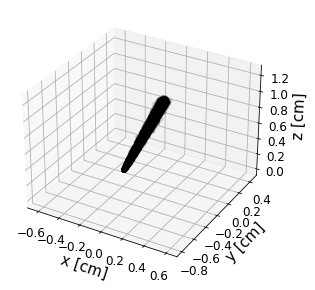

In [87]:
# Plot a Track
index = 0
track = tracks.iloc[index]["track"]
plot_track(track)

# Simulate readout


In [88]:
# the parameters, in order, are:
# peaking time [ns]
# digitization time [ns] 
# pitch of the x strips [cm]
# pitch of the y strips [cm]
# Threshold of x strips [No. electrons]
# Threshold of y strips [No. electrons]
# Charge sharing [lower strips / upper strips]
# Gain - extrapolating from PHA curve
# drift speed cm/ns
# Include charge integration effect.
# z resolution in cm, must be specified if Charge_integration = False

def sim_readout(tracks, peaking_time = 200, digit_t  = 250, pitch_x = 0.02, pitch_y = 0.02,thres_x = 82/9.0*6241.5, thres_y =  82/4.5*6241.5, CS = 0.62, Gain = 505.7, v_drift = 0.0008, Charge_integration = True, pitch_z = 0.02):

    # Readout is 10 cm x 10 cm
    x_bins = np.arange(-5,5,pitch_x)
    y_bins = np.arange(-5,5,pitch_y)

    # Find strip edges in x and y
    Left_edges_x = x_bins[0:-1]
    Right_edges_x = x_bins[1:]
    Left_edges_y = y_bins[0:-1]
    Right_edges_y = y_bins[1:]


    hits = pd.DataFrame(columns = ['strips_x', 'strips_y', 'times_x', 'times_y','electrons_x','electrons_y'])

    for index, row in tracks.iterrows():

        track = row.track

        x_positions = []
        x_charges = []
        x_times = []

        for L_edge,R_edge in zip(Left_edges_x,Right_edges_x):

            # Bin track over specific strip in x
            T_track = track[(track[:,0]> L_edge) &  (track[:,0]< R_edge)]

            # If there is charge above this strip
            if len(T_track > 0):


                # If we are incuding the effects of finite charge integration time followed by digitization time
                if Charge_integration == True:

                    # Get time distribution of charge over this strip
                    time_dist = T_track[:,2]/v_drift

                    # Shift so that min is t = 0ns
                    min_time = np.min(time_dist)
                    time_dist= time_dist-min_time

                    # Keeping only the charge withing peaking time
                    time_dist = time_dist [time_dist < peaking_time]

                    # compute mean time for the hit
                    mean_time = np.mean(time_dist)+min_time

                    # obtain detected charge taking into account primary ionization, gain, and charge sharing
                    charge_detected = len(time_dist) *Gain * CS / (CS+1.0)

                    if charge_detected > thres_x:
                        
                        # obtain mean time for the hit
                        x_times += [mean_time]
                        # obtain position of the hit
                        x_positions += [ (L_edge+R_edge)/2.0 ]
                        # obtain detected charge taking into account primary ionization, gain, and charge sharing
                        x_charges += [ charge_detected ]

                # Otherwise we bin the time axis according to the specified z resolution
                else:

                    # Bin in the z-dimension
                    z_bins = np.arange(0,1.2+pitch_z,pitch_z)
                    hist, bin_edges = np.histogram(T_track[:,2],bins=z_bins)
                    bin_centers = (bin_edges[1:]+bin_edges[:-1])/2

                    bin_centers = bin_centers[hist>0]
                    hist = hist[hist>0]

                    charge_detected = hist *Gain * CS / (CS+1.0)

                    # only keep hits above threshol
                    bin_centers = bin_centers[charge_detected>thres_x]
                    charge_detected = charge_detected [charge_detected>thres_x]


                    x_times += list(bin_centers/v_drift)
                    x_positions += list( np.ones(len(bin_centers)) * ((L_edge+R_edge)/2.0) )
                    x_charges += list(charge_detected)

        

        y_positions = []
        y_charges = []
        y_times = []

        for L_edge,R_edge in zip(Left_edges_y,Right_edges_y):

            # Bin track over specific strip in x
            T_track = track[(track[:,1]> L_edge) &  (track[:,1]< R_edge)]

            # If there is charge above this strip
            if len(T_track > 0):

                # If we are incuding the effects of finite charge integration time followed by digitization time
                if Charge_integration == True:

                    # Get time distribution of charge over this strip
                    time_dist = T_track[:,2]/v_drift

                    # Shift so that min is t = 0ns
                    min_time = np.min(time_dist)
                    time_dist= time_dist-min_time

                    # Keeping only the charge withing peaking time
                    time_dist = time_dist [time_dist < peaking_time]

                    # compute mean time for the hit
                    mean_time = np.mean(time_dist)+min_time

                    # obtain detected charge taking into account primary ionization, gain, and charge sharing
                    charge_detected = len(time_dist) * Gain / (CS+1.0)

                    if charge_detected > thres_y:

                        # obtain mean time for the hit
                        y_times += [mean_time]
                        # obtain position of the hit
                        y_positions += [ (L_edge+R_edge)/2.0 ]
                        # obtain detected charge taking into account primary ionization, gain, and charge sharing
                        y_charges += [ charge_detected ]

                # Otherwise we bin the time axis according to the specified z resolution
                else:

                    # Bin in the z-dimension
                    z_bins = np.arange(0,1.2+pitch_z,pitch_z)
                    hist, bin_edges = np.histogram(T_track[:,2],bins=z_bins)
                    bin_centers = (bin_edges[1:]+bin_edges[:-1])/2

                    bin_centers = bin_centers[hist>0]
                    hist = hist[hist>0]

                    charge_detected = hist * Gain / (CS+1.0)

                    # only keep hits above threshol
                    bin_centers = bin_centers[charge_detected>thres_y]
                    charge_detected = charge_detected [charge_detected>thres_y]


                    y_times += list(bin_centers/v_drift)
                    y_positions += list( np.ones(len(bin_centers)) * ((L_edge+R_edge)/2.0) )
                    y_charges += list(charge_detected)

        hits = hits.append({'strips_x' : np.array(x_positions), 'strips_y' : np.array(y_positions), 'times_x' : np.array(x_times), 'times_y' : np.array(y_times), 'electrons_x' :  np.array(x_charges), 'electrons_y' : np.array(y_charges) }, ignore_index = True)
        
    return hits


In [89]:
hits = sim_readout(tracks)
tracks = pd.concat([tracks,hits],axis=1)
tracks.head()


,direction,start,track,strips_x,strips_y,times_x,times_y,electrons_x,electrons_y
0,"[-0.3759877547494517, 0.14405578273346023, -0....","[0.22275082484569053, -0.249554606363659, 1.2]","[[0.22783412615885906, -0.22168574135464858, 1...","[-0.25000000000010125, -0.23000000000010168, -...","[-0.17000000000010296, -0.15000000000010338, -...","[62.21239574967905, 123.81404777151099, 185.34...","[740.3519132890153, 601.411201580996, 473.8442...","[166637.51481481481, 156573.46049382715, 16760...","[133916.85185185182, 165757.22222222222, 26221..."
1,"[-0.12454099291721997, -0.3785725719615389, -0...","[0.05026794916566735, 0.4959955935743703, 1.2]","[[0.032822689644728356, 0.4779660472743795, 1....","[-0.11000000000010424, -0.09000000000010466, -...","[0.009999999999893205, 0.02999999999989278, 0....","[73.12960888792566, 179.15368654998315, 333.79...","[36.9167320045939, 89.74183468574182, 150.5095...","[306953.6567901234, 330371.93703703705, 242698...","[217888.024691358, 256908.08641975306, 275949...."
2,"[0.1625987742831401, -0.37385442219959064, -0....","[0.33450448921672815, 0.3537119841632794, 1.2]","[[0.3582920002091224, 0.32969232616388056, 1.2...","[0.3899999999998851, 0.4099999999998847, 0.429...","[-0.1300000000001038, -0.11000000000010424, -0...","[986.9976266431416, 842.3255787818932, 747.984...","[36.6314019253839, 84.88170851870692, 147.6347...","[69480.68271604937, 66771.12962962962, 129671....","[165132.9012345679, 276262.037037037, 256283.7..."
3,"[-0.222521441556727, -0.3383540520401658, -0.9...","[-0.2915409505070684, 0.39503192486287597, 1.2]","[[-0.28803814027863406, 0.4076727161440828, 1....","[-0.5700000000000944, -0.5500000000000949, -0....","[-0.030000000000105942, -0.010000000000106368,...","[73.45369737852566, 175.90802846983473, 274.29...","[65.99549181143831, 134.0236300476534, 200.344...","[278116.27037037036, 269019.9135802469, 260891...","[302795.6790123457, 285939.012345679, 282193.0..."
4,"[0.2658281904093142, 0.2759284379326497, -0.92...","[-0.20261273133505397, 0.4254393748638957, 1.2]","[[-0.18502727689592927, 0.4340659174215605, 1....","[-0.2100000000001021, -0.17000000000010296, -0...","[0.42999999999988425, 0.4499999999998838, 0.46...","[1459.4140597431324, 1307.602437936289, 1229.9...","[1429.0204038833947, 1352.9187107972195, 1255....","[70254.84074074074, 102769.47777777778, 132574...","[170751.79012345677, 184799.012345679, 141720...."


# Perform 3D Reconstruction

In [90]:
# enter reconstruction parameters here

def Reconst3D_v1 (strips_x,strips_y,times_x,times_y,electrons_x,electrons_y,start,direction, v_drift = 0.0008, mu = -6.7, sigma = 16.4 , n_sigma = 3, plot = True, save_name = None,plot_truth = False ):
    # This 3D reconstruction algorithim only matches x and y hits if they are within a time window specified by mu, sigma, n_sigma
    # After x and y hits are matched, the x ADCs are spread evenly among all matched y hits and vice versa
    # The time is the average of the x hit time and y hit time
    # Unmatched hits are spread along all matched vertices via a time-weighted spread

    # Truth array - contains truth value for x and y hits that fire within the time gap window.
    # i.e. if Tarray_{ij} = True, then the ith x hit and the jth y hit are within the gap window
    # and should be combined, this constitutes an xy-hit
    Tarray = np.abs((np.subtract.outer(times_x,times_y)-mu) / sigma) < n_sigma

    # This counts the number of simultaniously triggering y hits for each x hit
    TCol = np.sum(Tarray,axis=1)*1.0
    # This counts the number of simultaniously triggering x hits for each y hit
    TRow = np.sum(Tarray,axis=0)*1.0
            
    # Throw an error if there are unmatched hits
    # This can be updated later
    if (0 in TCol) or (0 in TRow):
        print("Warning: Unmatched hits. Performing time-weighted spread")

    # Collect unmatched hit info
    # Convert ADC to electron count units
    unmatched_ADCs = np.append(electrons_x[ TCol == 0 ], electrons_y[ TRow == 0 ])
    # Shift x and y times based on mean offset
    unmatched_times = np.append( times_x[ TCol == 0 ] - (mu/2.0) ,  times_y[ TRow == 0 ] + (mu/2.0) )

    # Rebuild arrays, ommiting unmatched hits
    # Convert ADC to electron count units
    x_times = times_x[ TCol > 0 ]
    ADC_x = electrons_x[ TCol > 0 ]
    strips_x = strips_x[ TCol > 0 ]
    y_times = times_y[ TRow > 0 ]
    ADC_y = electrons_y[ TRow > 0 ] 
    strips_y = strips_y[ TRow > 0 ]
    Tarray = np.abs((np.subtract.outer(x_times,y_times)-mu) / sigma) < n_sigma
    TCol = np.sum(Tarray,axis=1)*1.0
    TRow = np.sum(Tarray,axis=0)*1.0

    # This divides the ADC of the x hit by the number of simultaniously triggering y hits
    ADCx_V = np.divide(ADC_x,TCol)

    # This is a matrix of the x ADC contribution to all xy-hits
    elecx_M = np.multiply(ADCx_V[..., None],Tarray)

    # This divides the ADC of the y hit by the number of simultaniously triggering x hits
    ADCy_V = np.divide(ADC_y,TRow)

    # This is a matrix of the y ADC contribution to all xy-hits
    elecy_M = np.multiply(ADCy_V,Tarray)

    # This is the total ADC assigned to each xy-hit
    elec_M = elecx_M+elecy_M

    # This holds the x strip position for each xy-hit
    Stripx_M = np.multiply(strips_x[..., None],Tarray)

    # This holds the y strip position for each xy-hit
    Stripy_M = np.multiply(strips_y,Tarray)

    # This holds the x time measurment for each xy-hit
    Timex_M = np.multiply(x_times[..., None],Tarray)

    # This holds the y time measurment for each xy-hit
    Timey_M = np.multiply(y_times,Tarray)

    # This holds the average time measurment for each xy-hit
    Time_M = (Timex_M + Timey_M) / 2.0

    # absolute time offsets between matched vertices and unmatched hits
    abs_t_off = np.abs( Time_M-np.tensordot(unmatched_times, Tarray, axes=0) )
    # Really we want to weight by the inverse time difference 
    abs_t_off = np.reciprocal(abs_t_off,where= abs_t_off!=0)

    # Corresponding umatched ADC and time offset normalization factor
    ADC_norm = unmatched_ADCs/abs_t_off.sum(axis=1).sum(axis=1)

    # Multiply togather and sum to get total unmatched ADC contribution for each vertex
    unmatched_contrib = (abs_t_off*np.tensordot(ADC_norm, Tarray, axes=0)).sum(axis=0)

    # Add to ADC matrix
    elec_M += unmatched_contrib


    x_vals = Stripx_M[Tarray]
    y_vals = Stripy_M[Tarray]
    weights = elec_M[Tarray]                            # Weight is number of electrons
    z_vals  = Time_M[Tarray] * v_drift                     # multiply by drift speed for z
    z_vals = z_vals - np.min(z_vals)                    # Shift z_vals so that minimum is at z=0

    if (plot == True) or (save_name != None):

        t_params = np.arange(0,-start[2]/direction[2],0.01)

        true_x = start[0]+t_params*direction[0]
        true_y = start[1]+t_params*direction[1]
        true_z = start[2]+t_params*direction[2]

        # Plot the 3D scatter
        fig = plt.figure()
        ax = Axes3D(fig)

        #set color map
        cm = plt.get_cmap('jet')
        cNorm = matplotlib.colors.Normalize(vmin=250000, vmax=650000)
        scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
                
        ax.scatter(x_vals, y_vals, z_vals, c=scalarMap.to_rgba(weights),s=300)
        if plot_truth == True:
            ax.plot(true_x,true_y,true_z, color=colors["black"])
        scalarMap.set_array(weights)
        fig.colorbar(scalarMap,label="No. electrons")

        set_axes_equal(ax)



        # Set labels
        ax.set_xlabel('x [cm]')
        ax.set_ylabel('y [cm]')
        ax.set_zlabel('z [cm]')
        ax.set_box_aspect(None, zoom=0.85)




        
                
        if plot == True:
            plt.show()
        if save_name != None:
            fig.savefig("./figures/"+save_name+".pdf",bbox_inches='tight')

    return x_vals, y_vals, z_vals, weights

/Users/majdghrear/anaconda3/envs/my_root_env/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in reciprocal
/Users/majdghrear/anaconda3/envs/my_root_env/lib/python3.7/site-packages/ipykernel_launcher.py:103: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.


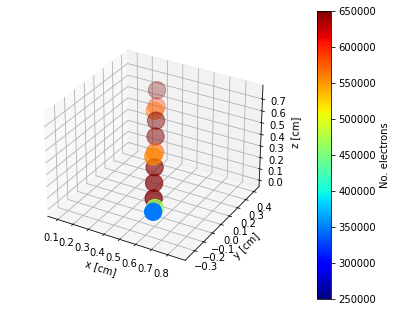

In [91]:
# plot a single track
track = tracks.iloc[2]
tracks
x,y,z,c = Reconst3D_v1(track.strips_x, track.strips_y, track.times_x, track.times_y, track.electrons_x, track.electrons_y,start=track.start,direction=track.direction, plot = True, save_name = "sim_alpha",plot_truth =False )


# Assess point resolution

In [92]:
def get_PR(tracks, mu = -6.7, sigma = 16.4 , n_sigma = 3):

    # Analyze point resolution
    all_z = np.array([])
    all_x_err_1 = np.array([])
    all_y_err_1 = np.array([])
    all_x_err_2 = np.array([])
    all_y_err_2 = np.array([])



    for index, row in tracks.iterrows():

        try:
            x,y,z,c = Reconst3D_v1(row.strips_x, row.strips_y, row.times_x, row.times_y, row.electrons_x, row.electrons_y,start=row.start,direction=row.direction, mu = -6.7, sigma = 16.4 , n_sigma = 3, plot = False, save_name = None)

            # Only consider tracks with 5 or more points
            if len(x) > 10:
                    
                # Get mismeasurements and absolute z values
                z_vals, delta_xs_1, delta_ys_1, delta_xs_2, delta_ys_2, v_PA, x_b = GetTransErrs( x,y,z,c, charge_weighting = True)

                all_z = np.append(all_z,z_vals)
                all_x_err_1 = np.append(all_x_err_1,delta_xs_1)
                all_y_err_1 = np.append(all_y_err_1,delta_ys_1)
                all_x_err_2 = np.append(all_x_err_2,delta_xs_2)
                all_y_err_2 = np.append(all_y_err_2,delta_ys_2)

        except:
            pass 


    # conver mismeaurments to cm 
    all_x_err_1 = all_x_err_1 * 10000
    all_y_err_1 = all_y_err_1 * 10000
    all_x_err_2 = all_x_err_2 * 10000
    all_y_err_2 = all_y_err_2 * 10000

    # Git mismeasurement versus abs. z using method 1
    abs_z, x_sigmas2, x_sigmas_err2, y_sigmas2, y_sigmas_err2, abs_z_std, x_std, y_std = Mismeasurment_vs_z(z_vals=all_z, x_mis=all_x_err_2 , y_mis = all_y_err_2, plot=False)




    plt.figure()
    plt.errorbar(abs_z,np.abs(x_sigmas2),x_sigmas_err2, color=colors["blue"],fmt='o',label="x strips", capthick=2)
    plt.errorbar(abs_z,np.abs(y_sigmas2),y_sigmas_err2, color=colors["red"],fmt='o',label="y strips", capthick=2)
    #plt.plot(abs_z_std,x_std,color=colors["blue"])
    #plt.plot(abs_z_std,y_std,color=colors["red"])
    plt.legend()
    plt.ylim((0,200))
    plt.xlabel("Abs. z [cm]")
    plt.ylabel("Effective Point Resolution [um]")
    plt.show()

    return np.abs(x_sigmas2), x_sigmas_err2, np.abs(y_sigmas2), y_sigmas_err2, abs_z

sigma x:  43.941916604954365 +/- 4.95664989480586
sigma y:  37.90005171050231 +/- 2.487598983739932
sigma x:  38.48621333278289 +/- 1.9349231985499356
sigma y:  40.98132503946445 +/- 2.2232070492484617
sigma x:  37.731079839663956 +/- 2.0369169192870067
sigma y:  52.18375206051086 +/- 5.20677768174272
sigma x:  43.76500987413422 +/- 2.98925807493156
sigma y:  48.938785701892726 +/- 3.5669027830285973
sigma x:  45.53543830524456 +/- 4.142083282397401
sigma y:  45.89418240671783 +/- 3.6916156900152135
sigma x:  39.78462656305069 +/- 1.0614869232238553
sigma y:  41.91565856743122 +/- 1.1315652944687062


/Users/majdghrear/anaconda3/envs/my_root_env/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in reciprocal


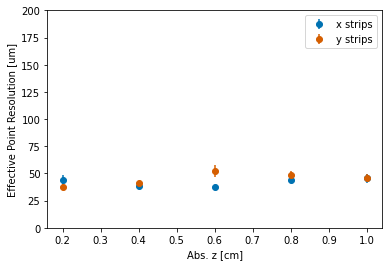

In [93]:
x_res, x_res_err, y_res, y_res_err, abs_z = get_PR(tracks)

# Simulate Po210 in UH DLC Quadrant a



In [94]:
# Make dataframe to store all results

df_resolution = pd.DataFrame(columns = ['Name','x_res', 'x_res_err', 'y_res', 'y_res_err','abs_z'])

sigma x:  34.045612937729175 +/- 0.7774841621400261
sigma y:  32.464293076702376 +/- 0.7001572914125886
sigma x:  37.93117629440438 +/- 0.8847999379596257
sigma y:  37.59738400218201 +/- 0.8736214967563497
sigma x:  42.20198972003951 +/- 1.2043095895696574
sigma y:  38.875991060642214 +/- 1.030747209938418


/Users/majdghrear/anaconda3/envs/my_root_env/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in reciprocal


sigma x:  42.63917056429171 +/- 1.2376609354612629
sigma y:  42.40094483842005 +/- 1.1615729741957437
sigma x:  47.9637718642048 +/- 2.2652213950494833
sigma y:  46.00410842189366 +/- 2.1103929363400784
sigma x:  -39.44182834770615 +/- 0.4607059962506303
sigma y:  -38.39156822145133 +/- 0.4203783970944736


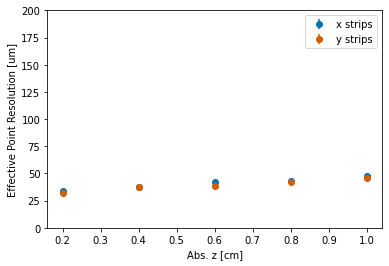

In [95]:
Charge_sharing = 0.41
Gain = 505.7
pitch_x = 0.02
pitch_y = 0.02
electronic_gain_x = 9.0
electronic_gain_y = 4.5
# 3D clustering paramters
mu = T_off.iloc[0]["Mu"]
sigma = T_off.iloc[0]["Sigma"]
n_sigma = 3

# simulatue tracks
tracks = sim_p210(n_sims = 500, DL = 1.2, Diff = True, DTrans = 0.0135, DLong = 0.0129, W = 35.2)

# simulate readout
hits = sim_readout(tracks, peaking_time = 200, digit_t  = 250, pitch_x = pitch_x, pitch_y = pitch_y,thres_x = 82/electronic_gain_x*6241.5, thres_y =  82/electronic_gain_y*6241.5, CS = Charge_sharing, Gain = Gain, v_drift = 0.0008, Charge_integration = True, pitch_z = 0.02)
tracks = pd.concat([tracks,hits],axis=1)

# Reconstruct and get point resolutions
x_res, x_res_err, y_res, y_res_err, abs_z = get_PR(tracks, mu = mu, sigma = sigma , n_sigma = n_sigma)

df_resolution = df_resolution.append({'Name' : "UH_DLC_a", 'x_res' : x_res, 'x_res_err' : x_res_err, 'y_res' : y_res, 'y_res_err' :  y_res_err, 'abs_z' : abs_z }, ignore_index = True)



# Simulate Po210 in UH NoDLC Quadrant a

/Users/majdghrear/anaconda3/envs/my_root_env/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in reciprocal


sigma x:  35.791632016640094 +/- 0.7563048047957545
sigma y:  35.18306153858504 +/- 0.7420353250853728
sigma x:  36.263705497496524 +/- 0.772270965779326
sigma y:  37.957143598248685 +/- 0.9042310778405518
sigma x:  40.36596448779886 +/- 0.9434529290896498
sigma y:  40.663258798128375 +/- 0.9574552697175642
sigma x:  42.8672281980414 +/- 0.9604699177008608
sigma y:  43.16182026067846 +/- 1.009023942218917
sigma x:  44.44093588215638 +/- 1.1279077222489415
sigma y:  45.18929916049426 +/- 1.188783674161261
sigma x:  -39.60783426666044 +/- 0.3941409118825028
sigma y:  -39.79660337675826 +/- 0.4104498960316406


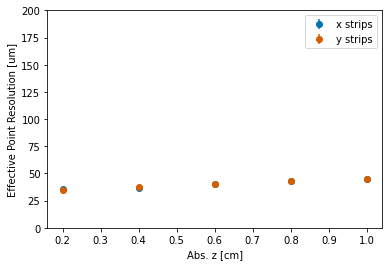

In [96]:
Charge_sharing = 0.62
Gain = 630.8
pitch_x = 0.02
pitch_y = 0.02
electronic_gain_x = 9.0
electronic_gain_y = 4.5
# 3D clustering paramters
mu = T_off.iloc[4]["Mu"]
sigma = T_off.iloc[4]["Sigma"]
n_sigma = 3

# simulatue tracks
tracks = sim_p210(n_sims = 500, DL = 1.2, Diff = True, DTrans = 0.0135, DLong = 0.0129, W = 35.2)

# simulate readout
hits = sim_readout(tracks, peaking_time = 200, digit_t  = 250, pitch_x = pitch_x, pitch_y = pitch_y,thres_x = 82/electronic_gain_x*6241.5, thres_y =  82/electronic_gain_y*6241.5, CS = Charge_sharing, Gain = Gain, v_drift = 0.0008, Charge_integration = True, pitch_z = 0.02)
tracks = pd.concat([tracks,hits],axis=1)

# Reconstruct and get point resolutions
x_res, x_res_err, y_res, y_res_err, abs_z = get_PR(tracks, mu = mu, sigma = sigma , n_sigma = n_sigma)

df_resolution = df_resolution.append({'Name' : "UH_NoDLC_a", 'x_res' : x_res, 'x_res_err' : x_res_err, 'y_res' : y_res, 'y_res_err' :  y_res_err, 'abs_z' : abs_z }, ignore_index = True)



# Simulate Po210 in UoS

sigma x:  40.56625036440854 +/- 1.8554779326656698
sigma y:  34.444773219054376 +/- 1.6690208566163975
sigma x:  42.462545457024305 +/- 1.9656106776320232
sigma y:  39.95694579568049 +/- 1.8642747571056064
sigma x:  44.86889831933474 +/- 1.9973618809550826
sigma y:  42.98039218550542 +/- 1.9715056645985165
sigma x:  48.57121169117198 +/- 2.9270697790934275
sigma y:  37.95575493493734 +/- 1.9413190937064924
sigma x:  45.949871226153576 +/- 3.2969897231223806
sigma y:  46.382618878975286 +/- 2.858795795838446
sigma x:  43.20380738222673 +/- 0.9012746659528378
sigma y:  39.638908683950284 +/- 0.8303332465837411


/Users/majdghrear/anaconda3/envs/my_root_env/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in reciprocal


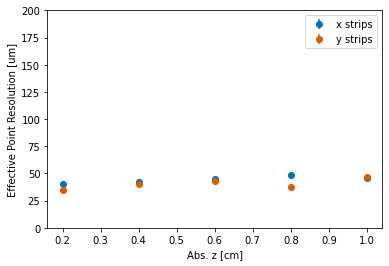

In [97]:
Charge_sharing = 0.13
Gain = 6490
pitch_x = 0.025
pitch_y = 0.025
electronic_gain_x= 1.0
electronic_gain_y = 1.0
# 3D clustering paramters
mu = T_off.iloc[8]["Mu"]
sigma = T_off.iloc[8]["Sigma"]
n_sigma = 3

# simulatue tracks
tracks = sim_p210(n_sims = 500, DL = 1.2, Diff = True, DTrans = 0.0135, DLong = 0.0129, W = 35.2)

# simulate readout
hits = sim_readout(tracks, peaking_time = 200, digit_t  = 250, pitch_x = pitch_x, pitch_y = pitch_y,thres_x = 82/electronic_gain_x*6241.5, thres_y =  82/electronic_gain_y*6241.5, CS = Charge_sharing, Gain = Gain, v_drift = 0.0008, Charge_integration = True, pitch_z = 0.02)
tracks = pd.concat([tracks,hits],axis=1)

# Reconstruct and get point resolutions
x_res, x_res_err, y_res, y_res_err, abs_z = get_PR(tracks, mu = mu, sigma = sigma , n_sigma = n_sigma)

df_resolution = df_resolution.append({'Name' : "UoS", 'x_res' : x_res, 'x_res_err' : x_res_err, 'y_res' : y_res, 'y_res_err' :  y_res_err, 'abs_z' : abs_z }, ignore_index = True)



In [98]:
df_resolution.to_pickle("./data/resolution_sim.pk")
df_resolution

,Name,x_res,x_res_err,y_res,y_res_err,abs_z
0,UH_DLC_a,"[34.045612937729175, 37.93117629440438, 42.201...","[0.7774841621400261, 0.8847999379596257, 1.204...","[32.464293076702376, 37.59738400218201, 38.875...","[0.7001572914125886, 0.8736214967563497, 1.030...","[0.2, 0.4, 0.6, 0.8, 1.0]"
1,UH_NoDLC_a,"[35.791632016640094, 36.263705497496524, 40.36...","[0.7563048047957545, 0.772270965779326, 0.9434...","[35.18306153858504, 37.957143598248685, 40.663...","[0.7420353250853728, 0.9042310778405518, 0.957...","[0.2, 0.4, 0.6, 0.8, 1.0]"
2,UoS,"[40.56625036440854, 42.462545457024305, 44.868...","[1.8554779326656698, 1.9656106776320232, 1.997...","[34.444773219054376, 39.95694579568049, 42.980...","[1.6690208566163975, 1.8642747571056064, 1.971...","[0.2, 0.4, 0.6, 0.8, 1.0]"


# Appendix: Using charge-weighted std

In [18]:
# A function which bins missmeasurments in z and fits them to Gaussians, outputting the results
def Mismeasurment_vs_z_weighted( z_vals, x_mis , y_mis , charge, start = 0.1, stop = 1.0, step = 0.2):

    abs_z_std = []
    x_std_weighted = []
    y_std_weighted = []

    for z_low in np.arange(start,stop,step):

        #make data cut
        z_high = z_low + step
        data_cut = (z_vals > z_low) & (z_vals < z_high)

        x_temp = x_mis[data_cut]
        y_temp = y_mis[data_cut]
        charge_temp = charge[data_cut]
        #charge_temp = np.ones(len(x_temp))

        x_std_weighted += [np.sqrt(np.dot(x_temp*charge_temp,x_temp)/np.sum(charge_temp))]
        y_std_weighted += [np.sqrt(np.dot(y_temp*charge_temp,y_temp)/np.sum(charge_temp))]

        abs_z_std += [round( (z_low+z_high)/2.0 ,2)]


            


    return  abs_z_std, x_std_weighted, y_std_weighted



/Users/majdghrear/anaconda3/envs/my_root_env/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in reciprocal


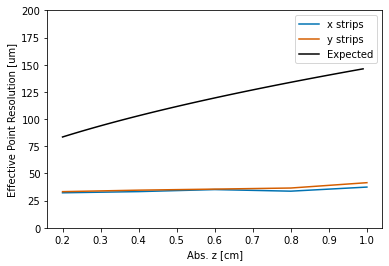

In [14]:
# Analyze point resolution
all_z = np.array([])
all_x_err_1 = np.array([])
all_y_err_1 = np.array([])
all_x_err_2 = np.array([])
all_y_err_2 = np.array([])

all_c = np.array([])



for index, row in tracks.iterrows():

    x,y,z,c = Reconst3D_v1(row.strips_x, row.strips_y, row.times_x, row.times_y, row.electrons_x, row.electrons_y,start=row.start,direction=row.direction, plot = False, save_name = None)

    # Only consider tracks with 5 or more points
    if len(x) > 5:
            
        # Get mismeasurements and absolute z values
        z_vals, delta_xs_1, delta_ys_1, delta_xs_2, delta_ys_2, v_PA, x_b = GetTransErrs( x,y,z,c, charge_weighting = True)

        all_z = np.append(all_z,z_vals)
        all_x_err_1 = np.append(all_x_err_1,delta_xs_1)
        all_y_err_1 = np.append(all_y_err_1,delta_ys_1)
        all_x_err_2 = np.append(all_x_err_2,delta_xs_2)
        all_y_err_2 = np.append(all_y_err_2,delta_ys_2)

        all_c = np.append(all_c,c)


# convert mismeaurments to cm 
all_x_err_1 = all_x_err_1 * 10000
all_y_err_1 = all_y_err_1 * 10000
all_x_err_2 = all_x_err_2 * 10000
all_y_err_2 = all_y_err_2 * 10000

# Git mismeasurement versus abs. z using method 1
abs_z_std, x_std, y_std = Mismeasurment_vs_z_weighted(z_vals=all_z, x_mis=all_x_err_2 , y_mis = all_y_err_2, charge = all_c)

x_ref = np.arange(0.2,1.0,0.01)
y_ref = np.sqrt( (pitch_x*10000/np.sqrt(12))**2 + (np.sqrt(x_ref)*DTrans*10000)**2 )


plt.figure()
plt.plot(abs_z_std,x_std,color=colors["blue"],label="x strips")
plt.plot(abs_z_std,y_std,color=colors["red"],label="y strips")
plt.plot(x_ref,y_ref,color=colors["black"],label="Expected")
plt.legend()
plt.ylim((0,200))
plt.xlabel("Abs. z [cm]")
plt.ylabel("Effective Point Resolution [um]")
plt.show()


Using a charge-weighted standard deviation agrees with the non-charge weighted standard deviation